<a href="https://colab.research.google.com/github/obaileyw-uncc/ecgr5105/blob/main/hw06_neuralnetworks/hw06_neuralnetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECGR 5105 Homework 6: Neural Network Applications
**Owen Bailey-Waltz (801488178)**

In [ ]:
# import required packages, load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn import datasets, metrics
import seaborn as sns
# from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from IPython.display import display

In [ ]:
# loss convergence plot from HW2
def plot_convergence(train_loss_history, val_loss_history):
  print("Training loss history: {}".format(train_loss_history))
  print("Validation loss history: {}".format(val_loss_history))

  # plot the loss over time
  plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, color='blue')
  plt.plot(range(1, len(train_loss_history) + 1), val_loss_history, color='orange')
  plt.grid(True)
  plt.legend(['Training', 'Validation'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss (J)')
  plt.title('Convergence of gradient descent (X)')
  plt.show()

## Problem 1: Diabetes dataset

In [ ]:
drive.mount('/content/drive/')
file_path = '/content/drive/MyDrive/datasets/diabetes.csv'
diabetes = pd.DataFrame(pd.read_csv(file_path))
diabetes.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# perform data pre-processing by splitting data PyTorch style
num_vars = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
y = diabetes.pop('Outcome')
X = diabetes[num_vars]
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [ ]:
#from pandas.core.indexers import validate_indices
X = torch.tensor(X.to_numpy(), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
n = X.shape[0]
n_val = int(0.2 * n)

shuffled_indices = torch.randperm(n)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([  9, 451, 502, 292, 169, 116, 338, 433, 402, 465, 108, 710, 630, 405,
         625,  60, 595, 526, 640, 672, 308, 675, 730, 555, 457, 430, 548, 157,
          97, 154, 635, 618, 523, 507, 263, 762, 582, 319, 515, 500,  49,  63,
         330, 420, 719, 760, 146, 454, 346, 510, 702,  85, 370, 506, 363, 248,
         380, 740, 724, 140, 401, 485, 628,  56,  24, 599, 474, 372, 367, 302,
         375, 161, 683, 447, 318, 122, 573,  84, 449, 312, 593, 610,  78, 725,
         540, 181, 728, 633, 758, 175, 337, 404, 406, 409, 349, 114, 765, 750,
         204, 381, 763, 335,  29, 467, 112, 721, 530, 436, 195, 446, 711, 561,
         159,  75, 519, 659, 564, 613, 142, 307, 567, 245, 329, 110, 705, 173,
         553, 718, 542, 369, 340, 753, 539, 612, 414, 400, 382, 205, 743, 689,
         386, 544, 661, 532, 463, 315, 387,  35, 678, 258,  81, 185, 581, 143,
         626, 432, 166, 240, 482, 196, 212, 620, 216, 668, 556, 397, 744, 324,
         471, 704, 353, 168, 278,  70, 674, 325, 221

In [ ]:
X_train = X[train_indices]
X_val = X[val_indices]
y_train = y[train_indices]
y_val = y[val_indices]

# standardize input features
for col in range(X_train.shape[1]):
  mu = torch.mean(X_train[:, col])
  sigma = torch.std(X_train[:, col])
  X_train[:, col] = (X_train[:, col] - mu) / sigma
  X_val[:, col] = (X_val[:, col] - mu) / sigma

In [ ]:
# modified training loop from example code
def model_train_classify(n_epochs, optimizer, model, loss_fn,
                X_train, X_val, y_train, y_val):
  loss_train_history = np.zeros(n_epochs)
  loss_val_history = np.zeros(n_epochs)
  for epoch in range(1, n_epochs + 1):
    h_train = model(X_train)
    loss_train = loss_fn(h_train, y_train)
    loss_train_history[epoch-1] = loss_train
    h_val = model(X_val)
    loss_val = loss_fn(h_val, y_val)
    loss_val_history[epoch-1] = loss_val

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if epoch == 1 or epoch % 200 == 0:
      print('Epoch {}: training loss {:.4f}, validation loss {:.4f}'.format(epoch, loss_train.item(),loss_val.item()))

  return loss_train_history, loss_val_history

Epoch 1: training loss 0.6614, validation loss 0.6213
Epoch 200: training loss 0.4781, validation loss 0.4778
Training loss history: [0.66135579 0.66020864 0.65910578 0.65804225 0.65701377 0.65601617
 0.65504557 0.65409845 0.65317154 0.65226197 0.65136671 0.65048337
 0.64960957 0.64874285 0.64788127 0.64702284 0.64616567 0.64530796
 0.64444804 0.64358455 0.64271581 0.64184058 0.64095742 0.64006519
 0.63916266 0.63824856 0.63732189 0.63638186 0.63542724 0.63445711
 0.63347071 0.63246721 0.63144583 0.63040584 0.62934667 0.62826771
 0.62716836 0.62604815 0.62490672 0.62374359 0.62255847 0.62135112
 0.62012142 0.61886919 0.61759424 0.61629683 0.61497676 0.61363441
 0.6122697  0.61088318 0.60947502 0.6080457  0.6065954  0.60512489
 0.60363477 0.60212559 0.60059792 0.59905279 0.59749085 0.59591293
 0.59431988 0.59271276 0.59109253 0.58946019 0.58781677 0.58616364
 0.58450156 0.58283186 0.58115572 0.57947439 0.57778907 0.57610101
 0.57441145 0.57272172 0.57103294 0.56934643 0.56766361 0.56598

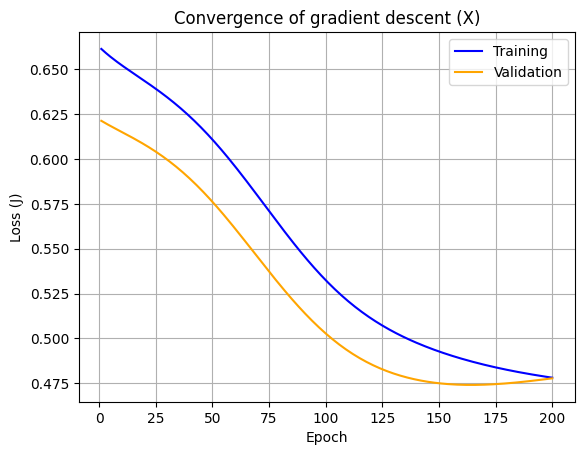

In [ ]:
# LogSoftmax binary classifier
# known good configuration
seq_model = nn.Sequential(nn.Linear(8,4), nn.Tanh(),
                          nn.Linear(4,2), nn.Tanh(),
                          nn.Linear(2,2),
                          nn.LogSoftmax(dim=1))

# seq_model = nn.Sequential(nn.Linear(8,4), nn.Tanh(),
#                           nn.Linear(4,3), nn.Tanh(),
#                           nn.Linear(3,2),
#                           nn.LogSoftmax(dim=1))
optimizer = optim.SGD(seq_model.parameters(), lr=1e-1)

loss_train, loss_val = model_train_classify(
    n_epochs=200,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.NLLLoss(),
    X_train=X_train,
    X_val=X_val,
    y_train=y_train,
    y_val=y_val
)
plot_convergence(loss_train, loss_val)

Training Accuracy: 0.7788617886178861
Validation Accuracy: 0.7450980392156863
Precision: 0.6
Recall: 0.5625
F1 Score: 0.5806451612903226



Text(50.722222222222214, 0.5, 'Actual')

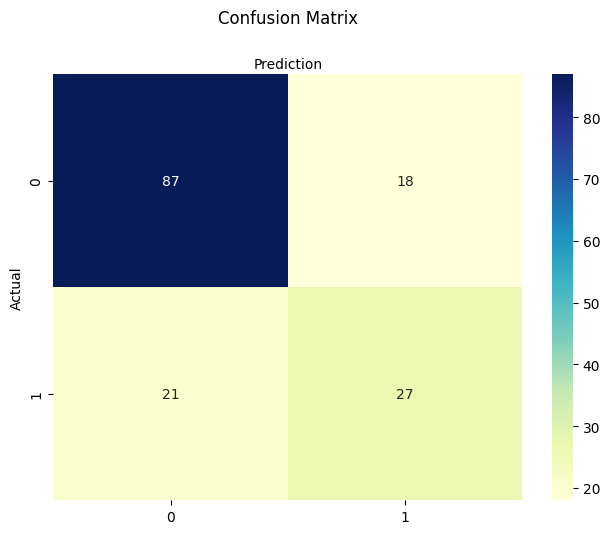

In [ ]:
_, labels_train = torch.max(seq_model(X_train), dim=1)
_, labels_val = torch.max(seq_model(X_val), dim=1)
confusion = metrics.confusion_matrix(y_val, labels_val)
training_metrics = {'Training Accuracy': metrics.accuracy_score(y_train, labels_train),
                    'Validation Accuracy': metrics.accuracy_score(y_val, labels_val),
                    'Precision': metrics.precision_score(y_val, labels_val),
                    'Recall': metrics.recall_score(y_val, labels_val),
                    'F1 Score': metrics.f1_score(y_val, labels_val)}

# print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
# coefficients = model.coef_[0]
# for i in range(len(coefficients)):
#   if coefficients[i] > 0:
#     print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
#   elif coefficients[i] < 0:
#     print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
# print()

for i in training_metrics:
  print("{}: {}".format(i, training_metrics[i]))
print()

# create heatmap for confusion matrix
# code frome example
classes = [0, 1]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

The behavior of stochastic gradient descent leads to a massive spread in the final model convergence. Large networks have a tendency to overfit, making small networks a good choice for this problem. The best performing network that was achieved had a training and validation accuracy of 77.1%, a precision of 66.0%, a sensitivity of 62.0% and an F1 score of 63.9%. The networks that came to be from stochastic gradient descent using the LogSoftmax output layer largely underperformed their counterparts that used vanilla gradient descent and support vector regression.

## Problem 2: Cancer dataset

In [ ]:
cancer = datasets.load_breast_cancer()
cancer_data = cancer.data
cancer_input = pd.DataFrame(cancer_data)

# label data features
labels = cancer.target
(i,) = labels.shape
labels = np.reshape(labels, (i, 1))
cancer_dataset = pd.DataFrame(np.concatenate([cancer_data,labels], axis=1))
cancer_dataset.columns = np.append(cancer.feature_names,'label')
cancer_dataset

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0


In [ ]:
# perform data pre-processing by splitting data PyTorch style
y = cancer_dataset.pop('label')
X = cancer_dataset
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
X = torch.tensor(X.to_numpy(), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
n = X.shape[0]
n_val = int(0.2 * n)

shuffled_indices = torch.randperm(n)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([227,  90, 177, 513, 141, 531, 480, 324, 184, 379, 223, 350, 216, 225,
         484, 221, 204, 490, 218, 541, 567, 219, 304, 479, 422,  46, 417, 489,
         125, 201,  64, 245, 368, 106, 159, 455,   7,   3,  72, 283, 503, 362,
         518, 428, 415, 322, 381,  98,  76, 488, 317, 425, 307, 220, 363, 170,
         384,  32, 263, 435, 535, 168, 123, 185, 474, 394, 103, 409, 542, 433,
          25, 392,  83, 418, 260,   9, 493, 437, 420,  54, 477, 349, 382, 179,
         311, 158, 429, 250,  43,  36,  38, 564, 100, 252, 305, 416, 241, 439,
         279, 492, 487, 270, 333, 457, 312, 339,  45, 191, 129, 238, 495, 235,
         208,  22,   0,  75, 257, 483, 340, 187,  19,  94,   1, 155, 247,  34,
         361,  84, 239, 374,  85, 456,  14, 299, 144, 478, 119, 566, 248,  52,
         199, 427, 393, 555, 293, 330,  80, 295, 443, 517, 458,  78, 413, 414,
           6, 228, 496,  99, 436, 376,  49, 320, 117,  16, 127,   4, 385, 364,
          20, 274, 269, 544, 126,  15, 249, 486,  97

In [ ]:
X_train = X[train_indices]
X_val = X[val_indices]
y_train = y[train_indices]
y_val = y[val_indices]

# standardize input features
for col in range(X_train.shape[1]):
  mu = torch.mean(X_train[:, col])
  sigma = torch.std(X_train[:, col])
  X_train[:, col] = (X_train[:, col] - mu) / sigma
  X_val[:, col] = (X_val[:, col] - mu) / sigma

Epoch 1: training loss 0.6898, validation loss 0.7233
Epoch 200: training loss 0.3619, validation loss 0.3746
Epoch 400: training loss 0.1896, validation loss 0.2091
Epoch 600: training loss 0.1271, validation loss 0.1540
Epoch 800: training loss 0.0980, validation loss 0.1315
Epoch 1000: training loss 0.0816, validation loss 0.1208
Epoch 1200: training loss 0.0711, validation loss 0.1148
Training loss history: [0.68980902 0.687828   0.68585742 ... 0.07122809 0.07118551 0.07114301]
Validation loss history: [0.72332746 0.72108293 0.71884906 ... 0.1148606  0.11483729 0.11481407]


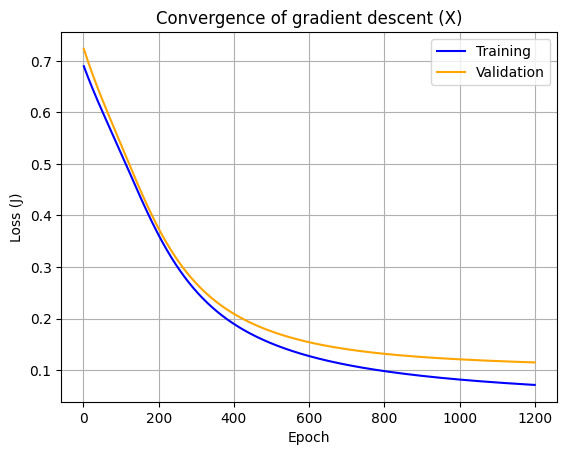

In [ ]:
# LogSoftmax binary classifier
# known good configuration
seq_model = nn.Sequential(nn.Linear(30,4), nn.Tanh(),
                          nn.Linear(4,2), nn.Tanh(),
                          nn.Linear(2,2),
                          nn.LogSoftmax(dim=1))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-2)

loss_train, loss_val = model_train_classify(
    n_epochs=1200,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.NLLLoss(),
    X_train=X_train,
    X_val=X_val,
    y_train=y_train,
    y_val=y_val
)
plot_convergence(loss_train, loss_val)

Training Accuracy: 0.9824561403508771
Validation Accuracy: 0.9823008849557522
Precision: 0.9714285714285714
Recall: 1.0
F1 Score: 0.9855072463768116



Text(50.722222222222214, 0.5, 'Actual')

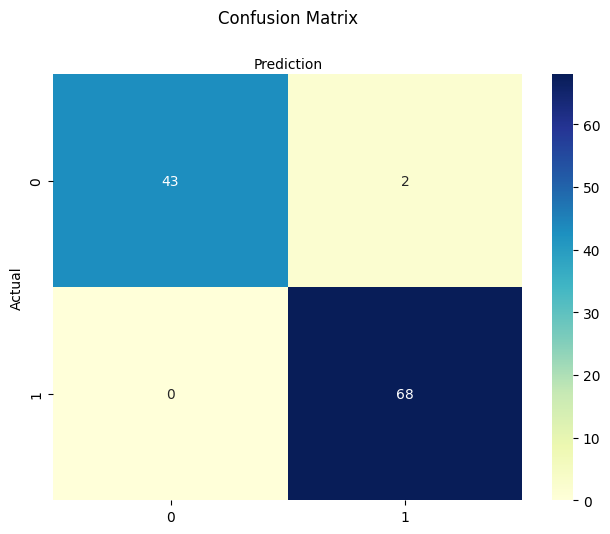

In [ ]:
_, labels_train = torch.max(seq_model(X_train), dim=1)
_, labels_val = torch.max(seq_model(X_val), dim=1)
confusion = metrics.confusion_matrix(y_val, labels_val)
training_metrics = {'Training Accuracy': metrics.accuracy_score(y_train, labels_train),
                    'Validation Accuracy': metrics.accuracy_score(y_val, labels_val),
                    'Precision': metrics.precision_score(y_val, labels_val),
                    'Recall': metrics.recall_score(y_val, labels_val),
                    'F1 Score': metrics.f1_score(y_val, labels_val)}

# print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
# coefficients = model.coef_[0]
# for i in range(len(coefficients)):
#   if coefficients[i] > 0:
#     print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
#   elif coefficients[i] < 0:
#     print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
# print()

for i in training_metrics:
  print("{}: {}".format(i, training_metrics[i]))
print()

# create heatmap for confusion matrix
# code from example
classes = [0, 1]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

The neural network machine learning model performs better than SVR or traditional logistic regression for the breast cancer dataset, producing better F1 scores along with better validation accuracy and recall. This may be a result of the difference in performance with a larger number of input features.

## Problem 3: CIFAR10 Image Classification

### (a) One hidden layer, 512 features

In [ ]:
# import dataset
from torchvision import datasets as tvd
from torchvision import transforms
data_path = '../data-unversioned/p1ch7'
cifar10 = tvd.CIFAR10(data_path, train=True, download=True,
                      transform=transforms.ToTensor())
cifar10_val = tvd.CIFAR10(data_path, train=False, download=True,
                          transform=transforms.ToTensor())

100%|██████████| 170M/170M [00:06<00:00, 24.8MB/s]


In [ ]:
# stack tensor in memory (see text)
imgs = torch.stack([img for img, _ in cifar10], dim=3)
imgs_val = torch.stack([img for img, _ in cifar10_val], dim=3)
imgs.shape, imgs_val.shape

(torch.Size([3, 32, 32, 50000]), torch.Size([3, 32, 32, 10000]))

In [ ]:
mu = imgs.view(3, -1).mean(dim=1)
sigma = imgs.view(3, -1).std(dim=1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mu, std=sigma)
])
cifar10 = tvd.CIFAR10(data_path, train=True, download=False,
                      transform=transform)
cifar10_val = tvd.CIFAR10(data_path, train=False, download=False,
                          transform=transform)

In [ ]:
# We're going to want CUDA for this one
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f'Now training on device {device}')

Now training on device cuda


In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
          'horse', 'ship', 'truck'] # labels map 1:1 to CIFAR10
n_out = 10
seq_model = nn.Sequential(nn.Linear(3072,512), nn.Tanh(),
                          nn.Linear(512,10))
seq_model = seq_model.to(device=device)

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                           shuffle=False)

alpha = 1e-2
optimizer = optim.SGD(seq_model.parameters(), lr=alpha)
n_epochs = 15
loss_fn = nn.CrossEntropyLoss()

loss_train_history = np.zeros(n_epochs)
loss_val_history = np.zeros(n_epochs)
for epoch in range(1, n_epochs + 1):
  for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    batch_size = imgs.shape[0]
    h_train = seq_model(imgs.view(batch_size, -1))
    loss_train = loss_fn(h_train, labels)
    loss_train_history[epoch-1] = loss_train

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

  total = 0
  correct = 0
  with torch.no_grad():
    for imgs, labels in val_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      batch_size = imgs.shape[0]
      h_val = seq_model(imgs.view(batch_size, -1))
      loss_val = loss_fn(h_val, labels)
      loss_val_history[epoch-1] = loss_val

      _, labels_val = torch.max(h_val, dim=1)

      confusion = metrics.confusion_matrix(labels.cpu(), labels_val.cpu())
      total += labels.shape[0]
      correct += int((labels == labels_val).sum())
      training_metrics = {'Accuracy': (correct / total),
                          'Precision': metrics.precision_score(labels.cpu(),
                                                               labels_val.cpu(),
                                                               average='macro',
                                                               zero_division=0),
                          'Recall': metrics.recall_score(labels.cpu(),
                                                         labels_val.cpu(),
                                                         average='macro',
                                                         zero_division=0),
                          'F1 Score': metrics.f1_score(labels.cpu(),
                                                       labels_val.cpu(),
                                                       average='macro',
                                                       zero_division=0)}

  print(f'Epoch {epoch}: training loss {loss_train:.4f},',
        f'validation loss {loss_val:.4f}')
  for i in training_metrics:
    print("{}: {}".format(i, training_metrics[i]))
  print()

Epoch 1: training loss 1.9896, validation loss 1.6051
Accuracy: 0.3946
Precision: 0.3611111111111111
Recall: 0.31481481481481477
F1 Score: 0.3216931216931217

Epoch 2: training loss 1.2885, validation loss 1.6634
Accuracy: 0.4184
Precision: 0.2777777777777778
Recall: 0.20370370370370366
F1 Score: 0.2222222222222222

Epoch 3: training loss 1.4705, validation loss 1.5952
Accuracy: 0.4298
Precision: 0.2314814814814815
Recall: 0.2222222222222222
F1 Score: 0.20017636684303353

Epoch 4: training loss 1.4028, validation loss 1.5807
Accuracy: 0.4358
Precision: 0.2685185185185185
Recall: 0.24074074074074073
F1 Score: 0.25026455026455025

Epoch 5: training loss 1.2561, validation loss 1.5463
Accuracy: 0.4481
Precision: 0.2777777777777778
Recall: 0.20370370370370366
F1 Score: 0.2222222222222222

Epoch 6: training loss 1.2406, validation loss 1.6679
Accuracy: 0.4514
Precision: 0.3611111111111111
Recall: 0.24074074074074073
F1 Score: 0.2693121693121693

Epoch 7: training loss 1.4335, validation los

Training loss history: [1.98961127 1.2885251  1.47049904 1.40283144 1.25609803 1.24061477
 1.43349242 1.43761873 1.18281746 1.29754221 1.19562137 1.1622057
 1.42572665 1.06786144 1.16460788]
Validation loss history: [1.60514915 1.66344416 1.59523356 1.58068609 1.54625535 1.66792965
 1.55553877 1.5941757  1.50938606 1.46242869 1.65532279 1.52316225
 1.48935962 1.52857399 1.49062216]


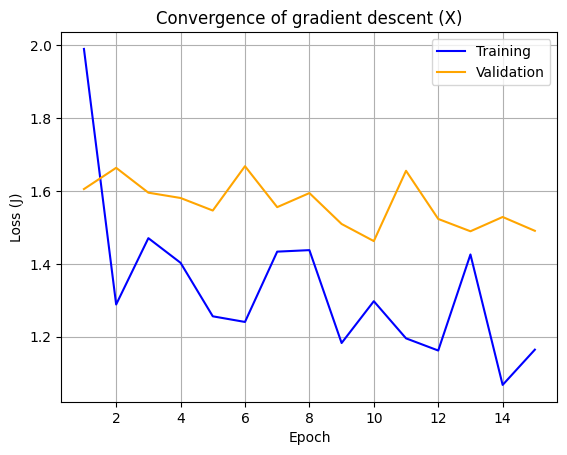

Text(50.722222222222214, 0.5, 'Actual')

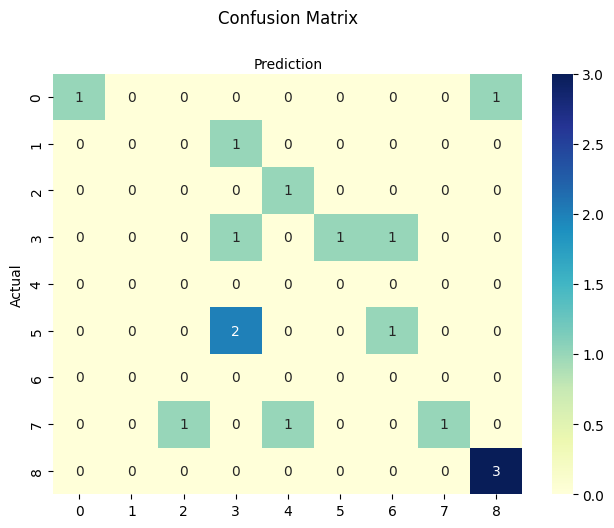

In [ ]:
# plot the convergence per epoch
plot_convergence(loss_train_history, loss_val_history)

# create heatmap for confusion matrix
# code frome example
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

This shallow classifier began to saturate its accuracy between 15 and 20 iterations. Beyond this iteration count, the classifier begins to overfit as validation loss begins to depart from training loss.

The performance of this classifier is very poor, with only a 47.79% accuracy achieved at the end of training and even worse performance in the areas of precision and recall.

### (b) Two more hidden layers


In [ ]:
n_out = 10
seq_model = nn.Sequential(nn.Linear(3072,48), nn.Tanh(),
                          nn.Linear(48,32), nn.Tanh(),
                          nn.Linear(32,8), nn.Tanh(),
                          nn.Linear(8,10))
seq_model = seq_model.to(device=device)

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                           shuffle=False)

alpha = 1e-2
optimizer = optim.SGD(seq_model.parameters(), lr=alpha)
n_epochs = 300
loss_fn = nn.CrossEntropyLoss()

loss_train_history = np.zeros(n_epochs)
loss_val_history = np.zeros(n_epochs)
for epoch in range(1, n_epochs + 1):
  for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    batch_size = imgs.shape[0]
    h_train = seq_model(imgs.view(batch_size, -1))
    loss_train = loss_fn(h_train, labels)
    loss_train_history[epoch-1] = loss_train

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

  total = 0
  correct = 0
  with torch.no_grad():
    for imgs, labels in val_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      batch_size = imgs.shape[0]
      h_val = seq_model(imgs.view(batch_size, -1))
      loss_val = loss_fn(h_val, labels)
      loss_val_history[epoch-1] = loss_val

      _, labels_val = torch.max(h_val, dim=1)

      confusion = metrics.confusion_matrix(labels.cpu(), labels_val.cpu())
      total += labels.shape[0]
      correct += int((labels == labels_val).sum())
      training_metrics = {'Accuracy': (correct / total),
                          'Precision': metrics.precision_score(labels.cpu(),
                                                               labels_val.cpu(),
                                                               average='macro',
                                                               zero_division=0),
                          'Recall': metrics.recall_score(labels.cpu(),
                                                         labels_val.cpu(),
                                                         average='macro',
                                                         zero_division=0),
                          'F1 Score': metrics.f1_score(labels.cpu(),
                                                       labels_val.cpu(),
                                                       average='macro',
                                                       zero_division=0)}

  print(f'Epoch {epoch}: training loss {loss_train:.4f},',
        f'validation loss {loss_val:.4f}')
  for i in training_metrics:
    print("{}: {}".format(i, training_metrics[i]))
  print()

Epoch 1: training loss 2.0312, validation loss 1.9785
Accuracy: 0.3145
Precision: 0.23333333333333334
Recall: 0.1
F1 Score: 0.13333333333333333

Epoch 2: training loss 1.8459, validation loss 1.8628
Accuracy: 0.3589
Precision: 0.1733333333333333
Recall: 0.13333333333333333
F1 Score: 0.13333333333333333

Epoch 3: training loss 1.8084, validation loss 1.7544
Accuracy: 0.3744
Precision: 0.23333333333333334
Recall: 0.2222222222222222
F1 Score: 0.20238095238095238

Epoch 4: training loss 1.8143, validation loss 1.6839
Accuracy: 0.3821
Precision: 0.2222222222222222
Recall: 0.2222222222222222
F1 Score: 0.19444444444444445

Epoch 5: training loss 1.4864, validation loss 1.5992
Accuracy: 0.3814
Precision: 0.2148148148148148
Recall: 0.2222222222222222
F1 Score: 0.1882716049382716

Epoch 6: training loss 1.6115, validation loss 1.6893
Accuracy: 0.3966
Precision: 0.20833333333333331
Recall: 0.2
F1 Score: 0.18015873015873013

Epoch 7: training loss 1.6215, validation loss 1.6043
Accuracy: 0.4009
Pr

Training loss history: [2.0311594  1.84594035 1.80839396 1.81425738 1.48642242 1.61152971
 1.6214596  1.30597472 1.85017037 2.17064285 1.60119224 1.22634506
 1.31204379 1.42966032 1.49946856 1.53789866 1.11598349 1.22997105
 1.49846995 1.16190195 1.46718407 1.2600286  1.43694746 0.91903126
 1.41840804 1.52991772 1.71287012 1.40420461 1.56227219 1.7651459
 1.52674556 1.06761289 1.31874824 0.97737944 1.13181543 1.4267683
 1.17419159 1.12038887 1.37566137 1.20457542 1.02823949 1.10834599
 1.08009124 1.05691528 1.02698278 1.24577308 0.96333277 1.58219862
 1.27775514 0.87890971 0.96423626 0.84490973 0.88329959 1.4397887
 0.88836861 1.06716514 1.13678741 1.38902473 0.75019455 1.37656844
 1.04235804 1.13192487 1.49433231 1.43270314 0.77993125 1.36182237
 0.61719865 0.92741054 0.71546674 1.17702997 0.86152798 1.16433144
 1.10623264 1.0336622  0.71238643 0.96228486 1.13335919 1.23380136
 0.71239024 1.32833886 1.01412177 0.59903711 1.29203558 0.97494239
 0.99317646 1.1645484  0.84011018 0.823477

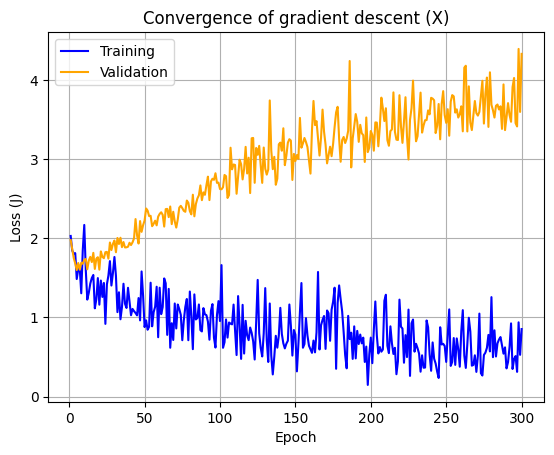

Text(50.722222222222214, 0.5, 'Actual')

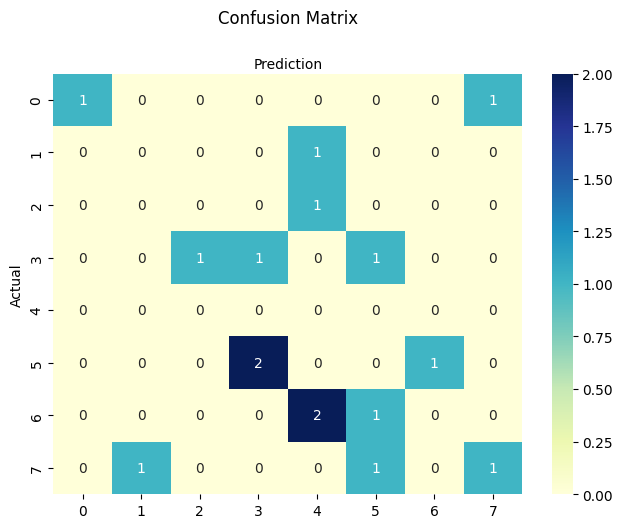

In [ ]:
# plot the convergence per epoch
plot_convergence(loss_train_history, loss_val_history)

# create heatmap for confusion matrix
# code frome example
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')